# IoT Network Traffic Classification with Neural Networks And RAG




## Dataset Preparation



In [ ]:
from sklearn.model_selection import train_test_split

# Define the train_val_test_split function
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

## Feature and Label Separation

We'll use the `remove_labels` function to separate features from labels in each dataset.

In [ ]:
# Define the remove_labels function
def remove_labels(df, label_name):
    X = df.drop(label_name, axis=1)
    y = df[label_name].copy()
    return (X, y)

## Data Loading and Concatenation

To prepare our dataset for training, we need to load data from multiple CSV files and combine them into a single DataFrame.

### Loading Data from CSV Files

The IoT-23 dataset consists of twenty-three captures (scenarios) of different IoT network traffic. These scenarios are divided into twenty network captures from infected IoT devices, each named after the malware sample executed on the scenario, and three network captures of real IoT devices' network traffic.

We will use the `pandas` library to read data from CSV files located in a specified directory. Each CSV file represents a portion of our dataset.


In [ ]:
import pandas as pd
import os

# --- Step 1: Define paths and cleaning parameters ---
directory = 'data'
cleaned_output_file = 'cleaned_data.csv'
is_first_file = True

# List of columns to drop immediately after loading each file
columns_to_drop = [
    'service', 'orig_bytes', 'resp_bytes', 'local_orig',
    'local_resp', 'tunnel_parents', 'duration', 'ts',
    'detailed-label', 'uid', 'missed_bytes'
]

# Dictionary to clean up the 'label' column
replacement_dict = {
    'Malicious   DDo': 'Malicious   DDoS',
    'Malicious   FileDownload': 'Malicious',
    'Malicious   Attack': 'Malicious',
    'M': 'Malicious',
    'Ma': 'Malicious',
    'Malicious   PartOfAHorizontal': 'Malicious   PartOfAHorizontalPortScan'
}

print("Starting chunk-based processing...")

# --- Step 2: Loop through files, clean them one by one, and append to a new CSV ---
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        print(f"--> Processing file: {filename}")

        # Read one single CSV file into memory
        df_chunk = pd.read_csv(os.path.join(directory, filename), delimiter='|', low_memory=False)

        # Perform ALL initial cleaning steps on this small chunk
        df_chunk.replace('-', pd.NA, inplace=True)
        df_chunk.drop(columns=columns_to_drop, inplace=True, errors='ignore')
        df_chunk.dropna(subset=['history', 'label'], inplace=True)
        df_chunk['label'] = df_chunk['label'].replace(replacement_dict)

        # Append the cleaned chunk to our new output file
        if is_first_file:
            # For the first file, write the header
            df_chunk.to_csv(cleaned_output_file, index=False, mode='w')
            is_first_file = False
        else:
            # For subsequent files, append without the header
            df_chunk.to_csv(cleaned_output_file, index=False, mode='a', header=False)

print("\nChunk processing complete. All files cleaned and merged into 'cleaned_data.csv'.")


# --- Step 3: Load the final, much smaller, cleaned DataFrame ---
print("Loading the final cleaned dataset into memory...")
final_df = pd.read_csv(cleaned_output_file)

# --- Step 4: Verify the result ---
print("\nSuccessfully loaded 'final_df'. Here is the new memory usage:")
final_df.info()

Starting chunk-based processing...
--> Processing file: CTU-IoT-Malware-Capture-42-1conn.log.labeled.csv
--> Processing file: CTU-IoT-Malware-Capture-9-1conn.log.labeled.csv
--> Processing file: CTU-IoT-Malware-Capture-44-1conn.log.labeled.csv
--> Processing file: CTU-IoT-Malware-Capture-8-1conn.log.labeled.csv
--> Processing file: CTU-IoT-Malware-Capture-60-1conn.log.labeled.csv
--> Processing file: CTU-IoT-Malware-Capture-1-1conn.log.labeled.csv
--> Processing file: CTU-IoT-Malware-Capture-48-1conn.log.labeled.csv
--> Processing file: CTU-IoT-Malware-Capture-35-1conn.log.labeled.csv

Chunk processing complete. All files cleaned and merged into 'cleaned_data.csv'.
Loading the final cleaned dataset into memory...

Successfully loaded 'final_df'. Here is the new memory usage:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2040577 entries, 0 to 2040576
Data columns (total 12 columns):
 #   Column         Dtype  
---  ------         -----  
 0   id.orig_h      object 
 1   id.orig_p   

## Summary

Finally, let's print some summary statistics about our combined dataset.

In [ ]:
print("Number of features:", len(final_df.columns))
print("Length of the dataset:", len(final_df))

Number of features: 12
Length of the dataset: 2040577


In [ ]:
final_df.head(200)

,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,conn_state,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label
0,192.168.1.197,58312.0,104.24.96.120,80.0,tcp,SF,ShADadttFf,54.0,3371.0,50.0,69224.0,Malicious
1,192.168.1.197,45082.0,104.24.97.120,80.0,tcp,SF,ShADadttFf,54.0,2938.0,50.0,69224.0,Malicious C&C
2,192.168.1.197,58316.0,104.24.96.120,80.0,tcp,S0,S,3.0,180.0,0.0,0.0,Benign
3,192.168.1.197,59357.0,192.168.1.1,53.0,udp,SF,Dd,2.0,114.0,2.0,202.0,Benign
4,192.168.1.197,39686.0,192.168.1.1,53.0,udp,SF,Dd,2.0,114.0,2.0,202.0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...
195,192.168.1.197,50852.0,185.244.25.183,4975.0,tcp,S0,S,1.0,60.0,0.0,0.0,Benign
196,192.168.1.197,50660.0,185.244.25.183,4975.0,tcp,S3,ShAdDaf,7.0,439.0,6.0,553.0,Benign
197,192.168.1.197,47411.0,192.168.1.1,53.0,udp,SF,Dd,1.0,57.0,1.0,73.0,Benign
198,192.168.1.197,46926.0,192.168.1.1,53.0,udp,SF,Dd,1.0,57.0,1.0,73.0,Benign


## Understanding the Dataset

Before proceeding further, let's take a closer look at the combined dataset `final_df` using the `info()` method. This method provides a concise summary of the DataFrame, including information about the columns, their data types, and any missing values. Understanding the structure of the dataset is essential for preprocessing and analysis tasks.

This command will display information such as the total number of entries, the data type of each column, and the number of non-null values. It will help us gain insights into the dataset's overall composition and identify any potential issues that need to be addressed during data preprocessing.

In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2040577 entries, 0 to 2040576
Data columns (total 12 columns):
 #   Column         Dtype  
---  ------         -----  
 0   id.orig_h      object 
 1   id.orig_p      float64
 2   id.resp_h      object 
 3   id.resp_p      float64
 4   proto          object 
 5   conn_state     object 
 6   history        object 
 7   orig_pkts      float64
 8   orig_ip_bytes  float64
 9   resp_pkts      float64
 10  resp_ip_bytes  float64
 11  label          object 
dtypes: float64(6), object(6)
memory usage: 186.8+ MB


## Descriptive Statistics

Understanding the distribution and summary statistics of the dataset's numerical features can provide valuable insights into its characteristics. We can use the `describe()` method to generate summary statistics for numerical columns.

In [ ]:
final_df.describe()

,id.orig_p,id.resp_p,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
count,2.040577e+06,2.040577e+06,2.040577e+06,2.040577e+06,2.040577e+06,2.040577e+06
mean,4.080805e+04,1.705717e+04,1.264644e+02,5.478066e+03,6.054072e-02,6.696491e+00
std,1.510390e+04,2.632061e+04,6.083763e+04,2.396935e+06,1.362514e+00,6.603378e+02
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.471300e+04,2.300000e+01,1.000000e+00,4.000000e+01,0.000000e+00,0.000000e+00
50%,4.376300e+04,2.300000e+01,1.000000e+00,6.000000e+01,0.000000e+00,0.000000e+00
75%,5.180400e+04,4.314800e+04,2.000000e+00,1.200000e+02,0.000000e+00,0.000000e+00
max,6.553500e+04,6.553500e+04,6.602735e+07,1.914793e+09,4.580000e+02,2.478440e+05


This command will display descriptive statistics such as count, mean, standard deviation, minimum, 25th percentile (Q1), median (50th percentile or Q2), 75th percentile (Q3), and maximum for each numerical column. These statistics help us understand the central tendency, dispersion, and shape of the numerical data distribution.

## Class Distribution

In classification tasks, it's essential to examine the distribution of classes to understand the balance or imbalance between different categories. We can use the `value_counts()` method on the target variable (e.g., `"label"`) to count the occurrences of each class.

In [ ]:
final_df["label"].value_counts()

,count
label,
Benign,617764
Malicious,611503
Malicious DDoS,444669
Malicious PartOfAHorizontalPortScan,366415
Malicious C&C,224
Malicious Pa,1
Ben,1


This command will return a series containing the counts of unique values in the target variable. Analyzing the class distribution helps in assessing the dataset's suitability for classification tasks and guides the selection of appropriate evaluation metrics.

## Data Processing

In this section, we'll preprocess the dataset to handle missing or undefined data effectively.

### Replace Hyphens with NA Values

We'll replace hyphens `('-')` with Pandas' `NA` values to better handle missing or undefined data.

In [ ]:
final_df.replace('-', pd.NA, inplace=True)

### Check for Null Values

We'll check for null values in the dataset and print the count of null values for each column.

In [ ]:
null_values = final_df.isnull().sum()
print(null_values)

id.orig_h        0
id.orig_p        0
id.resp_h        0
id.resp_p        0
proto            0
conn_state       0
history          0
orig_pkts        0
orig_ip_bytes    0
resp_pkts        0
resp_ip_bytes    0
label            0
dtype: int64


### Columns with Null Values

We'll identify columns with null values and print their percentages.

In [ ]:
null_values = final_df.isnull().sum()
null_percentage = (null_values / len(final_df)) * 100
columns_with_null = null_percentage[null_percentage > 0]
print("Columns with Null Values (Percentage):")
print(columns_with_null)

Columns with Null Values (Percentage):
Series([], dtype: float64)


### Drop Columns with Null Values

Finally, we'll drop columns with a significant number of null values to clean up the dataset.

### Drop Rows with Null Values in Specific Column

We'll also drop rows with null values in the `'history'` column.

In [ ]:
final_df.dropna(subset=['history'], inplace=True)

### Drop Rows with Null Label Values

We drop rows with null label values to ensure that each sample in the dataset is labeled properly.

In [ ]:
final_df = final_df.dropna(subset=['label'])

### Data Cleaning and Transformation

We update label values for consistency and clarity. For example, we replace 'Malicious DDo' with 'Malicious DDoS' to correct a typo and merge similar attack types under the 'Malicious' category.

In [ ]:
replacement_dict = {
    'Malicious   DDo': 'Malicious   DDoS',
    'Malicious   FileDownload': 'Malicious',
    'Malicious   Attack': 'Malicious',
    'M': 'Malicious',
    'Ma': 'Malicious',
    'Malicious   PartOfAHorizontal': 'Malicious   PartOfAHorizontalPortScan'
}

final_df['label'] = final_df['label'].replace(replacement_dict)

### Exploratory Data Analysis (EDA)

We visualize the distribution of attacks in the dataset to gain insights into the prevalence of different attack types.

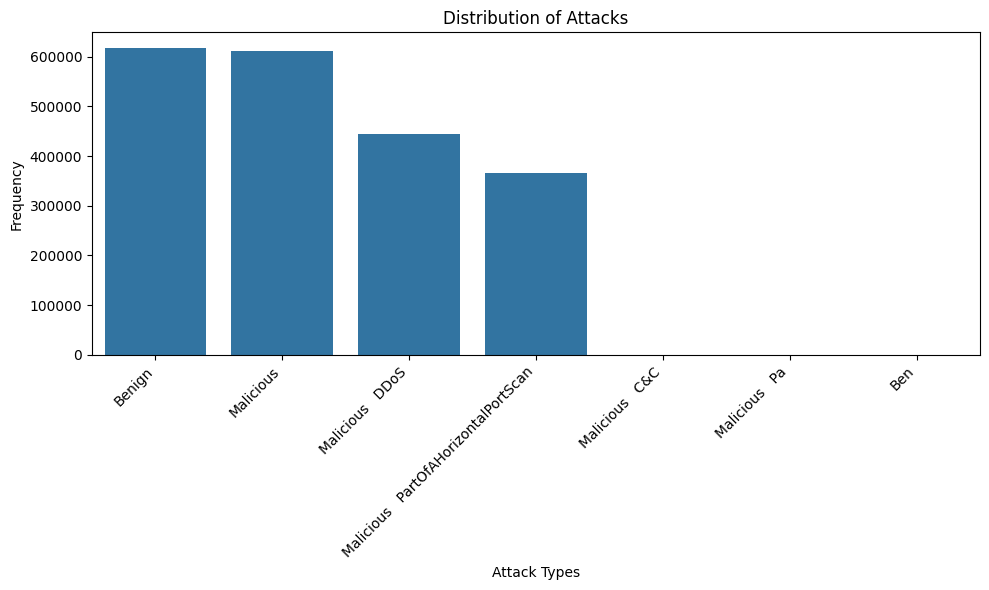

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the distribution of attacks using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=final_df["label"].value_counts().index, y=final_df["label"].value_counts().values)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Attack Types')
plt.ylabel('Frequency')
plt.title('Distribution of Attacks')
plt.tight_layout()
plt.show()

### Displaying the Processed Dataset

Finally, after performing the necessary preprocessing steps, it's beneficial to inspect the resulting dataset to ensure that the desired transformations have been applied correctly.

In [ ]:
final_df

,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,conn_state,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label
0,192.168.1.197,58312.0,104.24.96.120,80.0,tcp,SF,ShADadttFf,54.0,3371.0,50.0,69224.0,Malicious
1,192.168.1.197,45082.0,104.24.97.120,80.0,tcp,SF,ShADadttFf,54.0,2938.0,50.0,69224.0,Malicious C&C
2,192.168.1.197,58316.0,104.24.96.120,80.0,tcp,S0,S,3.0,180.0,0.0,0.0,Benign
3,192.168.1.197,59357.0,192.168.1.1,53.0,udp,SF,Dd,2.0,114.0,2.0,202.0,Benign
4,192.168.1.197,39686.0,192.168.1.1,53.0,udp,SF,Dd,2.0,114.0,2.0,202.0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...
2040572,192.168.1.196,40298.0,158.156.68.35,23.0,tcp,S0,S,1.0,60.0,0.0,0.0,Benign
2040573,192.168.1.196,36990.0,157.155.67.34,23.0,tcp,S0,S,1.0,60.0,0.0,0.0,Benign
2040574,192.168.1.196,59806.0,156.154.66.33,23.0,tcp,S0,S,1.0,60.0,0.0,0.0,Benign
2040575,192.168.1.196,60312.0,155.153.65.32,23.0,tcp,S0,S,1.0,60.0,0.0,0.0,Benign


This command displays the processed DataFrame, showing the effect of the preprocessing steps performed earlier.

### Encoding Categorical Features

Categorical features in the dataset need to be encoded into numerical representations before they can be used in machine learning models. One common approach is to use Label Encoding for categorical features, where each unique category is assigned a numerical label. Similarly, IP addresses need to be transformed into numerical representations.

In [ ]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
import pandas as pd
import joblib

# Hashing IP addresses
columns_to_hash = ['id.orig_h', 'id.resp_h']
for column in columns_to_hash:
    final_df[column] = final_df[column].apply(hash)

# Encoding categorical columns with LabelEncoder
categorical_columns_to_label_encoder = ['proto', 'conn_state', 'history']
for column in categorical_columns_to_label_encoder:
    print("column", column)
    # Initialize LabelEncoder
    categorical_label_encoder = LabelEncoder()
    # Fit and transform the column
    final_df[column] = categorical_label_encoder.fit_transform(final_df[column])
    # Save the LabelEncoder object for future use
    filename = f'categorical_label_encoder_{column}.pkl'
    joblib.dump(categorical_label_encoder, filename)
    # Print the classes encoded by LabelEncoder
    print("Categorical columns labels for", column, ":", categorical_label_encoder.classes_)

# Convert certain columns to numeric data types
final_df['id.orig_p'] = pd.to_numeric(final_df['id.orig_p'])
final_df['id.resp_p'] = pd.to_numeric(final_df['id.resp_p'])
final_df['orig_ip_bytes'] = pd.to_numeric(final_df['orig_ip_bytes'])
final_df['resp_pkts'] = pd.to_numeric(final_df['resp_pkts'])
final_df['resp_ip_bytes'] = pd.to_numeric(final_df['resp_ip_bytes'])


column proto
Categorical columns labels for proto : ['tcp' 'udp']
column conn_state
Categorical columns labels for conn_state : ['OTH' 'REJ' 'RSTO' 'RSTOS0' 'RSTR' 'RSTRH' 'S0' 'S1' 'S2' 'S3' 'SF' 'SH']
column history
Categorical columns labels for history : ['Aa' 'C' 'D' 'DAd' 'D^' 'DaFfA' 'Dd' 'DdA' 'DdAa' 'DdAaFf' 'F' 'Fr'
 'HaDdAfF' 'HaDdR' 'R' 'S' 'SAD' 'SaR' 'SahAdDrfR' 'ShA' 'ShADF'
 'ShADFadfRR' 'ShADFr' 'ShADa' 'ShADaF' 'ShADaFr' 'ShADadFf' 'ShADadR'
 'ShADadRf' 'ShADadf' 'ShADadfF' 'ShADadfR' 'ShADadtFf' 'ShADadtfF'
 'ShADadttFf' 'ShADadttfF' 'ShADafF' 'ShADafdtF' 'ShADafr' 'ShADar'
 'ShADarfF' 'ShADda' 'ShADdaf' 'ShADdafR' 'ShADdfFa' 'ShADfFr' 'ShADfdtR'
 'ShADfrFr' 'ShADr' 'ShADrfR' 'ShAF' 'ShAFa' 'ShAFf' 'ShAFfR' 'ShAFr'
 'ShAdDFar' 'ShAdDTafF' 'ShAdDaF' 'ShAdDaFR' 'ShAdDaFRf' 'ShAdDaFf'
 'ShAdDaFfr' 'ShAdDaFr' 'ShAdDaFrR' 'ShAdDaR' 'ShAdDaTF' 'ShAdDaTFf'
 'ShAdDaTFfR' 'ShAdDaTR' 'ShAdDaTfF' 'ShAdDaf' 'ShAdDafF' 'ShAdDafFr'
 'ShAdDafFrR' 'ShAdDafR' 'ShAdDafr' 'ShAdDafrFr' 

In this code snippet:

- The categorical columns in the DataFrame `final_df` are converted to string type to ensure uniformity.
- IP addresses in specified columns are hashed using a simple hash function to convert them into numerical representations while maintaining anonymity.
- Then, a `LabelEncoder` is applied to each categorical column, transforming the categorical values into numerical labels.
- The resulting numerical labels for categorical columns are saved as individual files using joblib for future use.
- Certain numerical columns like 'id.orig_p', 'id.resp_p', 'orig_ip_bytes', 'resp_pkts', and 'resp_ip_bytes' are converted to numeric data type using Pandas' `pd.to_numeric` function to ensure consistency in data type across the dataset.

### Splitting the Dataset

Before training a machine learning model, it's common practice to split the dataset into training, validation, and test sets. This helps in evaluating the model's performance on unseen data.

In [ ]:
train_set, val_set, test_set = train_val_test_split(final_df)

X_train, y_train = remove_labels(train_set, 'label')
X_val, y_val = remove_labels(val_set, 'label')
X_test, y_test = remove_labels(test_set, 'label')

In this code:

- The `final_df` dataset is split into training, validation, and test sets using the `train_val_test_split` function.
- The features (X) and labels (y) are separated from each dataset.

### Encoding Categorical Labels and One-Hot Encoding

In machine learning, it's common to work with categorical labels that need to be encoded into numerical form before feeding them into a model. Additionally, for classification tasks with multiple classes, it's beneficial to represent these encoded labels as one-hot encoded vectors. This section demonstrates how to perform label encoding and one-hot encoding using scikit-learn's `LabelEncoder` and Keras's `to_categorical` functions.

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit LabelEncoder on the entire 'label' column of the original dataframe
label_encoder.fit(final_df['label'])

# Encode labels in y_train using the fitted LabelEncoder
y_train_encoded = label_encoder.transform(y_train)

# Get unique labels after fitting on the entire dataset
unique_labels = label_encoder.classes_
print("Encoded Unique labels:", unique_labels)

# Convert encoded labels to one-hot vectors
y_train_encoded = to_categorical(y_train_encoded, num_classes=len(unique_labels))
print("Encoded y_train shape:", y_train_encoded.shape)


# Encode labels in y_val using the fitted LabelEncoder instance
y_val_encoded = label_encoder.transform(y_val)
print("Encoded y_val shape:", y_val_encoded.shape)


# Convert encoded labels to one-hot vectors
y_val_encoded = to_categorical(y_val_encoded, num_classes=len(unique_labels))


# Encode labels in y_test using the fitted LabelEncoder instance
y_test_encoded = label_encoder.transform(y_test)
print("Encoded y_test shape:", y_test_encoded.shape)


# Convert encoded labels to one-hot vectors
y_test_encoded = to_categorical(y_test_encoded, num_classes=len(unique_labels))

Encoded Unique labels: ['Ben' 'Benign' 'Malicious' 'Malicious   C&C' 'Malicious   DDoS'
 'Malicious   Pa' 'Malicious   PartOfAHorizontalPortScan']
Encoded y_train shape: (1224346, 7)
Encoded y_val shape: (408115,)
Encoded y_test shape: (408116,)


In [ ]:
import joblib

joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

**Explanation:**

- **Label Encoding:** The **`LabelEncoder`** is used to transform categorical labels into numerical representations. Each unique label is assigned a unique integer.
- **Handling Missing Values:** Rows with missing labels are dropped using **`dropna`** to maintain data integrity.
- **Fitting LabelEncoder:** The **`fit_transform`** method of **`LabelEncoder`** is used to fit and transform the training labels (`y_train`) into encoded form.
- **Unique Labels:** The **`classes_`** attribute of **`LabelEncoder`** provides the unique labels in alphabetical order.
- **One-Hot Encoding:** The **`to_categorical`** function from Keras is used to convert the encoded labels into one-hot encoded vectors. Each integer label is converted into a binary vector, where the index corresponding to the label is set to 1 and all other indices are set to 0.
- **Encoding Validation and Test Sets:** The same **`LabelEncoder`** instance is used to transform the validation (**`y_val`**) and test (**`y_test`**) labels into encoded form. Then, these encoded labels are converted into one-hot encoded vectors in a similar manner.

This process ensures that the categorical labels are appropriately encoded and transformed into a format suitable for training classification models, such as neural networks.

### Data Standardization with StandardScaler

Data standardization is a preprocessing technique used to transform the features of a dataset to have a mean of 0 and a standard deviation of 1. This process ensures that the features are on the same scale, which is essential for many machine learning algorithms, particularly those based on **distance metrics or gradient descent optimization**.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler to normalize the input data
scaler = StandardScaler()

# Normalize the training data (X_train)
X_train_scaled = scaler.fit_transform(X_train)

# Normalize the validation data (X_val) using the same scaler instance
X_val_scaled = scaler.transform(X_val)

# Normalize the test data (X_test) using the same scaler instance
X_test_scaled = scaler.transform(X_test)

In [ ]:
import joblib

joblib.dump(scaler, 'standard_scaler.pkl')

['standard_scaler.pkl']

In [ ]:
X_train_scaled

array([[-3.32295085e-01, -1.08820851e+00,  2.86786029e-01, ...,
        -2.31249307e-03, -4.49409222e-02, -9.85937449e-03],
       [-7.94515488e-01,  4.23849100e-01, -4.48742287e-01, ...,
        -1.67224738e-03,  2.52469435e+01,  5.08480691e+00],
       [-3.32295085e-01,  1.48929484e+00,  2.86786029e-01, ...,
        -2.31249307e-03, -4.49409222e-02, -9.85937449e-03],
       ...,
       [ 2.03174476e+00,  1.55458162e+00, -1.71761039e+00, ...,
        -2.28833285e-03, -4.49409222e-02, -9.85937449e-03],
       [-3.32295085e-01,  9.01979218e-02,  2.86786029e-01, ...,
        -2.31249307e-03, -4.49409222e-02, -9.85937449e-03],
       [ 2.03174476e+00, -9.87100087e-01, -1.61924679e+00, ...,
        -2.28833285e-03, -4.49409222e-02, -9.85937449e-03]])

**Explanation:**

- **StandardScaler Initialization:** The StandardScaler class from scikit-learn is used to perform standardization. It standardizes features by removing the mean and scaling them to unit variance.
- **Fitting and Transforming:** The fit_transform method of StandardScaler is used to compute the mean and standard deviation of the training data (X_train) and then apply the transformation to standardize the features.
For validation and test datasets (X_val and X_test), the transform method is used to apply the same transformation learned from the training data.
- **Consistency Across Sets:** It's crucial to use the same scaler instance (scaler) to normalize all datasets (training, validation, and test) to ensure consistency in scaling across different sets.
- **Data Normalization Benefits:** Normalizing the input data helps improve the convergence speed of gradient-based optimization algorithms, reduces the sensitivity to the scale of features, and often leads to better performance of machine learning models.

By standardizing the input features, we ensure that each feature contributes equally to the model's learning process, leading to better overall performance and stability during training.

### Neural Network with Dropout

In this section, we'll explore the implementation of a neural network model that incorporates dropout layers. These techniques are commonly used to improve the performance and generalization of deep learning models.

#### Dropout:

Dropout is a regularization technique used to prevent overfitting by randomly dropping a fraction of the neurons during training. It helps in improving the generalization performance of the model by reducing the co-adaptation of neurons.

- **Implementation**: Dropout layers are added after each batch normalization layer in the model. They randomly deactivate a fraction of the neurons in the previous layer during each training iteration, forcing the network to learn more robust features.

#### Model Architecture:

The neural network model consists of input, hidden, and output layers:

- **Input Layer**: An input layer with the shape corresponding to the number of features in the input data.

- **Hidden Layers**: Multiple dense layers with batch normalization, activation functions (ReLU), and dropout. These layers capture the complex relationships in the data and prevent overfitting.

- **Output Layer**: A dense output layer with a softmax activation function, which produces probabilities for each class in a multi-class classification task.

#### Compilation:

The model is compiled with the Adam optimizer, categorical cross-entropy loss function, and evaluation metrics including accuracy and precision.

#### Benefits:
  
- **Preventing Overfitting**: Dropout layers prevent overfitting by randomly deactivating neurons, forcing the network to learn more generalizable features.
  
- **Better Generalization**: Using dropout can lead to better generalization performance on unseen data.

By incorporating dropout layers into the model architecture, you can build more robust and efficient deep learning models for various tasks.


In [ ]:
from tensorflow.keras import models, layers, regularizers

model = models.Sequential()

# Input layer
model.add(layers.Input(shape=(X_train_scaled.shape[1],)))

# Hidden layers
model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(256, kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(128, kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))

# Output layer
model.add(layers.Dense(len(unique_labels), activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy', 'Precision'])

### Model Summary

The `model.summary()` function provides a concise overview of the architecture and parameters of the neural network model. It displays the layers, their output shapes, and the number of parameters in each layer. This summary is useful for understanding the structure of the model and verifying its correctness.


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 512)            │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,271 (669.03 KB)

 Trainable params: 171,271 (669.03 KB)

 Non-trainable params: 0 (0.00 B)

After building the neural network model, calling `model.summary()` prints a summary table in the console or notebook output. This table includes information about each layer, such as the layer type, output shape, and number of trainable parameters.

### Training with Early Stopping

During model training, the `fit()` method is called with the training data, validation data, and other parameters including the number of epochs and batch size. The `callbacks` parameter is used to specify additional callbacks, such as early stopping.

- **Preventing Overfitting**: Early stopping helps prevent overfitting by stopping the training process when the model's performance on the validation set no longer improves.
  
- **Optimizing Training Time**: Early stopping can reduce training time by stopping the training process once the model has converged to its optimal performance.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train_scaled,
                    y_train_encoded,
                    epochs=8,
                    batch_size=32,
                    validation_data=(X_val_scaled, y_val_encoded),
                    callbacks=[early_stopping])

Epoch 1/8
38261/38261 ━━━━━━━━━━━━━━━━━━━━ 130s 3ms/step - Precision: 0.9824 - accuracy: 0.9792 - loss: 0.1520 - val_Precision: 0.9968 - val_accuracy: 0.9968 - val_loss: 0.0538
Epoch 2/8
38261/38261 ━━━━━━━━━━━━━━━━━━━━ 118s 3ms/step - Precision: 0.9949 - accuracy: 0.9948 - loss: 0.0621 - val_Precision: 0.9968 - val_accuracy: 0.9968 - val_loss: 0.0512
Epoch 3/8
38261/38261 ━━━━━━━━━━━━━━━━━━━━ 122s 3ms/step - Precision: 0.9949 - accuracy: 0.9948 - loss: 0.0573 - val_Precision: 0.9967 - val_accuracy: 0.9967 - val_loss: 0.0488
Epoch 4/8
38261/38261 ━━━━━━━━━━━━━━━━━━━━ 128s 3ms/step - Precision: 0.9947 - accuracy: 0.9946 - loss: 0.0574 - val_Precision: 0.9967 - val_accuracy: 0.9967 - val_loss: 0.0478
Epoch 5/8
38261/38261 ━━━━━━━━━━━━━━━━━━━━ 121s 3ms/step - Precision: 0.9947 - accuracy: 0.9946 - loss: 0.0564 - val_Precision: 0.9969 - val_accuracy: 0.9969 - val_loss: 0.0428
Epoch 6/8
38261/38261 ━━━━━━━━━━━━━━━━━━━━ 135s 4ms/step - Precision: 0.9946 - accuracy: 0.9946 - loss: 0.0564 - va

## Plotting Training History

### Loss vs. Epochs:

The first plot shows the training and validation loss over epochs. It provides insights into the model's convergence and whether it is overfitting or underfitting. A decreasing training loss indicates that the model is learning from the training data, while the validation loss indicates the model's performance on unseen data.

- **Implementation**: The training and validation loss data are extracted from the `history` object returned by the `fit()` method. These values are then plotted using `matplotlib.pyplot` to visualize the loss trends over epochs.

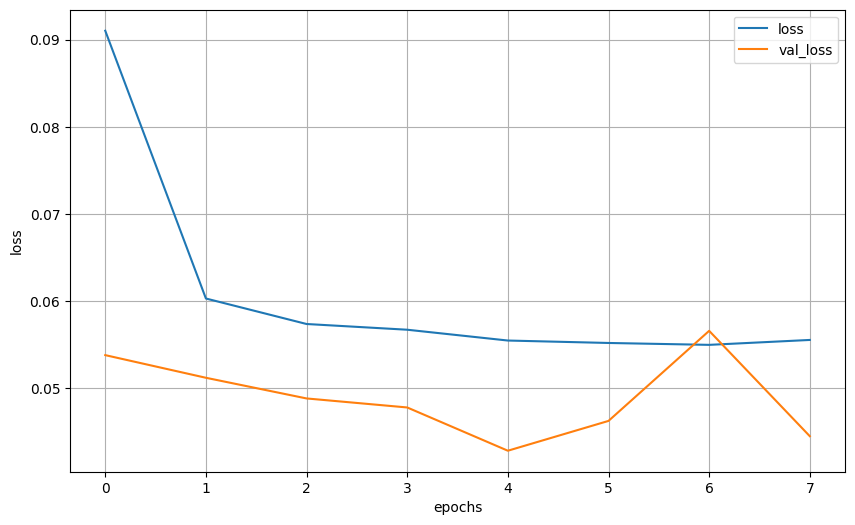

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history)[['loss', 'val_loss']].plot(figsize=(10, 6))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Accuracy vs. Epochs

The second plot shows the training and validation accuracy over epochs. It helps assess how well the model is performing on both the training and validation datasets. An increasing accuracy indicates that the model is improving in its ability to correctly classify samples.

- **Implementation:** Similar to the loss plot, the training and validation accuracy data are extracted from the **`history`** object and plotted using **`matplotlib.pyplot.`**

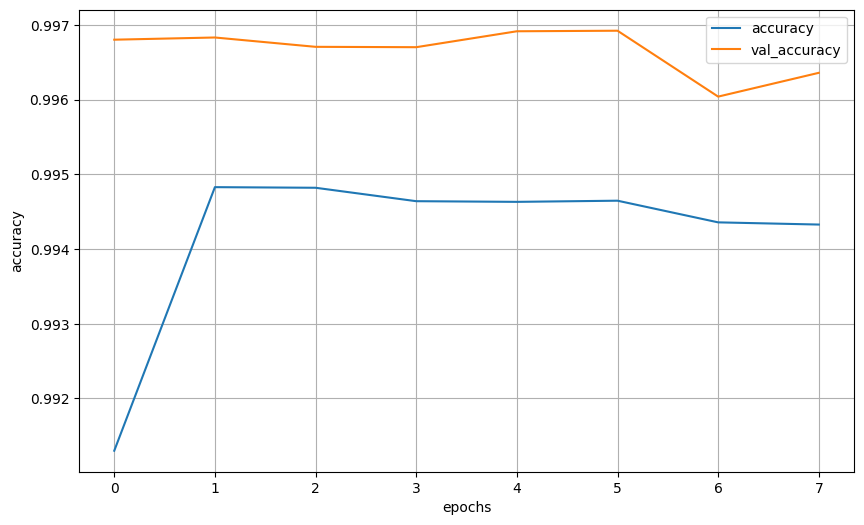

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(figsize=(10, 6))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()


- **Loss Plot:** Look for convergence of training and validation loss. If the training loss decreases but the validation loss starts to increase, it indicates overfitting.
- **Accuracy Plot:** Monitor the increase in accuracy over epochs. A large gap between training and validation accuracy may indicate overfitting.

These plots provide valuable insights into the training process and can help in tuning model hyperparameters.

## Model Evaluation

Once the model has been trained, it's crucial to evaluate its performance on a test dataset to understand how well it generalizes to unseen data. To do this, we use the evaluate function provided by the Keras API in TensorFlow.



In [ ]:
error, accuracy, precision = model.evaluate(X_test_scaled, y_test_encoded)
print("Error: ", error)
print("Accuracy: ", accuracy)
print("Precision: ", precision)

12754/12754 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - Precision: 0.9966 - accuracy: 0.9966 - loss: 0.0443
Error:  0.04377944394946098
Accuracy:  0.9967509508132935
Precision:  0.9967557787895203


- **Error:** It is the loss obtained by the model on the test dataset.
- **Accuracy:** It is the model's accuracy on the test dataset, i.e., the fraction of samples classified correctly.
- **Precision:** It is a measure of the model's precision in predicting positive samples relative to all samples predicted as positive.

These values provide us with a quantitative understanding of the model's performance and help us determine its effectiveness in the classification task.

In [ ]:
!pip install tensorflow scikit-learn seaborn pandas matplotlib

## Saving the Trained Model and Weights

After training a deep learning model, it's essential to save both the model architecture and its trained weights for future use or deployment. We can achieve this in TensorFlow using the **`save`** method provided by the Keras API.

In [ ]:
# Define the file paths for saving the model and weights
model_path = 'trained_model/model.keras' # Changed to .keras format
weights_path = 'trained_model/weights.weights.h5' # weights can still be saved in h5

# Save the trained model architecture
model.save(model_path)

# Save the trained model weights
model.save_weights(weights_path)

This code saves the entire model architecture to a single HDF5 file **(model.h5)** and the trained weights to another HDF5 file **(weights.h5)**. These files can then be loaded later to make predictions on new data or continue training the model.

In [ ]:
# Install necessary libraries
!pip install -q -U ipywidgets
!pip install -q -U google-generativeai

import ipywidgets as widgets
from IPython.display import display, clear_output
import google.generativeai as genai
import joblib
from tensorflow import keras
import pandas as pd
import numpy as np
import json
import os
try:
    from google.colab import userdata
    GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
    genai.configure(api_key=GOOGLE_API_KEY)
    print("Gemini API configured successfully!")
except (ImportError, userdata.SecretNotFoundError) as e:
    print("ERROR: Could not find GOOGLE_API_KEY. Please follow the instructions above to set it up in Colab Secrets.")

Gemini API configured successfully!


In [ ]:
# Load the trained model and preprocessors
try:
    model = keras.models.load_model('trained_model/model.h5')
    scaler = joblib.load('standard_scaler.pkl')
    label_encoder = joblib.load('label_encoder.pkl')
    proto_encoder = joblib.load('categorical_label_encoder_proto.pkl')
    conn_state_encoder = joblib.load('categorical_label_encoder_conn_state.pkl')
    history_encoder = joblib.load('categorical_label_encoder_history.pkl')
    print("All models and preprocessors loaded successfully.")
except FileNotFoundError as e:
    print(f"ERROR: Could not load a required file. Make sure all saved assets are available. Details: {e}")

All models and preprocessors loaded successfully.


In [ ]:
# This dictionary acts as our simple "knowledge base" for the RAG system.
RAG_KNOWLEDGE_BASE = {
    "Benign": "This is considered normal, safe traffic. It doesn't exhibit patterns associated with malicious activity. Features like low packet counts and standard connection states (e.g., 'SF' for successful connections) are common.",
    "Malicious   DDoS": "A Distributed Denial-of-Service (DDoS) attack aims to overwhelm a server or network with a flood of internet traffic. Key indicators often include a very high number of packets or bytes from a single source, and connection states like 'S0' (connection attempt seen, no reply), suggesting many unanswered connection requests.",
    "Malicious   C&C": "This is Command and Control (C&C) traffic. It indicates that a compromised machine inside the network is communicating with an external attacker's server to receive commands or send back stolen data. This traffic can sometimes be subtle, but may involve unusual ports or connection patterns.",
    "Malicious   PartOfAHorizontalPortScan": "This traffic is part of a horizontal port scan, where an attacker rapidly tries to connect to the same port on many different computers in a network. It's a reconnaissance technique to find vulnerable machines. The model likely detected a pattern of repeated connection attempts to a specific port from this source IP.",
    # Add other labels from your dataset here as needed
    "default": "The traffic type is not well-documented in our knowledge base."
}

def explain_with_gemini(prediction, user_input_json):
    """
    Uses the Gemini API to generate a detailed explanation of the prediction.
    """
    if not GOOGLE_API_KEY:
        return "Gemini API key not configured. Cannot generate explanation."

    # Use a specific model name that supports generateContent
    model_gen = genai.GenerativeModel('gemini-2.5-flash')

    # RAG Step 1: Retrieval
    context = RAG_KNOWLEDGE_BASE.get(prediction, RAG_KNOWLEDGE_BASE["default"])

    # RAG Step 2: Augmented Prompt
    prompt = f"""
    You are a helpful cybersecurity analyst explaining a machine learning model's prediction to a student.

    **Context about the predicted traffic type:**
    {context}

    **The user's input data that was classified:**
    {user_input_json}

    **Task:**
    Based on the context and the user's data, provide a clear, step-by-step explanation.
    1.  Start by stating the prediction in a bold, clear sentence.
    2.  In simple terms, explain what this type of traffic is.
    3.  Look at the user's input data and point out 1-2 features that are likely strong indicators for this prediction, based on the context. For example, if it's a DDoS attack, mention if the 'orig_ip_bytes' is high.
    4.  Conclude with a brief summary.
    """

    try:
        response = model_gen.generate_content(prompt)
        return response.text
    except Exception as e:
        return f"An error occurred while generating the explanation with Gemini: {e}"

In [ ]:
# --- Define the preprocessing function for a single input ---
def preprocess_input(data_df):
    # Hashing IP addresses
    data_df['id.orig_h'] = data_df['id.orig_h'].apply(hash)
    data_df['id.resp_h'] = data_df['id.resp_h'].apply(hash)

    # Encoding categorical columns with the loaded encoders
    data_df['proto'] = proto_encoder.transform(data_df['proto'])
    data_df['conn_state'] = conn_state_encoder.transform(data_df['conn_state'])
    data_df['history'] = history_encoder.transform(data_df['history'])

    # Ensure all columns are in the correct order as in the training data
    # (assuming X_train is available from the notebook)
    X_train_columns = ['id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p', 'proto', 'conn_state', 'history', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes']
    data_df = data_df[X_train_columns]

    # Scaling the features
    scaled_data = scaler.transform(data_df)
    return scaled_data

# --- Create UI Widgets ---
style = {'description_width': 'initial'}
json_input = widgets.Textarea(
    value='{"id.orig_h": "192.168.1.197", "id.orig_p": 58316.0, "id.resp_h": "104.24.96.120", "id.resp_p": 80.0, "proto": "tcp", "conn_state": "S0", "history": "S", "orig_pkts": 500.0, "orig_ip_bytes": 30000.0, "resp_pkts": 0.0, "resp_ip_bytes": 0.0}',
    placeholder='Paste your JSON here',
    description='Network Traffic Data (JSON):',
    layout={'width': '90%', 'height': '150px'},
    style=style
)

run_button = widgets.Button(
    description="Classify and Explain",
    button_style='success',
    tooltip='Click to run the model'
)

output_area = widgets.Output()

# --- Define the Button Click Event ---
def on_button_clicked(b):
    with output_area:
        clear_output()
        print("Processing...")
        try:
            # Get and parse user input
            input_json = json_input.value
            input_data = json.loads(input_json)
            input_df = pd.DataFrame([input_data])

            # Preprocess the data
            processed_data = preprocess_input(input_df.copy()) # Use a copy

            # Get MLP prediction
            prediction_probs = model.predict(processed_data)
            predicted_index = np.argmax(prediction_probs, axis=1)[0]
            predicted_label = label_encoder.inverse_transform([predicted_index])[0]

            clear_output()
            # Display MLP Result
            print("--- MLP Model Classification ---")
            display(widgets.HTML(f"<h2>Prediction: <span style='color:red;'>{predicted_label}</span></h2>"))

            # Get and display Gemini RAG explanation
            print("\n--- Detailed Explanation (from Gemini API) ---")
            explanation = explain_with_gemini(predicted_label, input_json)
            display(widgets.HTML(f"<p>{explanation.replace('*', '').replace('`', '')}</p>"))


        except json.JSONDecodeError:
            clear_output()
            print("ERROR: Invalid JSON format. Please check your input.")
        except Exception as e:
            clear_output()
            print(f"An error occurred: {e}")

run_button.on_click(on_button_clicked)

# --- Display the Application ---
display(widgets.VBox([json_input, run_button, output_area]))